# Homework 1

Name: Stanly Gomes

Student ID: 801118166

GitHub Repository: https://github.com/NaraPvP/RealTimeML

## Problem 1
Develop a multi-layer perceptron with two hidden layers (you pick the dimensions of the hidden layers) for Fashionmnst dataset.

In [ ]:
!pip install torchmetrics
!pip install d2l==1.0.0b0

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Subset

from torchvision import transforms, datasets
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix

from d2l import torch as d2l

In [181]:
def cpu():  #@save
    return torch.device('cpu')
def gpu(i=0):  #@save
    return torch.device(f'cuda:{i}')
cpu(), gpu(), gpu(1)

(device(type='cpu'),
 device(type='cuda', index=0),
 device(type='cuda', index=1))

In [182]:
def num_gpus():  #@save
    return torch.cuda.device_count()
num_gpus()

1

In [183]:
def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

In [184]:
d2l.use_svg_display()

### 1.a. train the model from scratch (with randomized parameters) and plot the results (training loss and accuracy, validation accuracy) after 20 epochs.

In [185]:
class FashionMNIST(d2l.DataModule):  #@save
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

In [186]:
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val)

(60000, 10000)

In [187]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

In [ ]:
# Since this function is changed for weight decay, its reinitialized here
@d2l.add_to_class(d2l.Classifier)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)

In [188]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [189]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [234]:
# class MLPScratch(d2l.Classifier):
#     def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
#         super().__init__()
#         self.save_hyperparameters()
#         self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
#         self.b1 = nn.Parameter(torch.zeros(num_hiddens))
#         self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
#         self.b2 = nn.Parameter(torch.zeros(num_outputs))
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(int(num_hiddens/2)),
                                 nn.ReLU(), nn.LazyLinear(int(num_hiddens/4)),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

In [235]:
@d2l.add_to_class(d2l.Classifier)
def training_step(self, batch):
  l = self.loss(self(*batch[:-1]), batch[-1])
  Y_hat = self(*batch[:-1])
  self.plot('loss', l, train=True)
  self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=True)
  return l

In [236]:
@d2l.add_to_class(d2l.Classifier)
def validation_step(self, batch):
  Y_hat = self(*batch[:-1])
  # self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
  self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

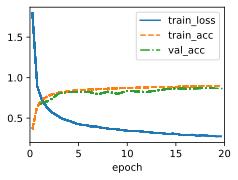

In [237]:
# model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
# model.cuda()
# data
# trainer = d2l.Trainer(max_epochs=10)
# trainer.fit(model, data)
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)

1a. Based on the plot, there could have been more epochs used since the training loss was still decreasing at a consistent rate. Surprisingly, there doesn't seem to be overfitting in this initial training. There were some points where the generalization gap increased, but it ended up very close to each other.

In [238]:
# Save model and parameters
torch.save(model.state_dict(), 'mlp_1a.params')

### 1.b Report section a; this time add weight penalties (weight decays). Report and plot your training results. how do the training results change compared to the baseline? (15pts)

In [223]:
@d2l.add_to_class(d2l.Classifier)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=0.01)   

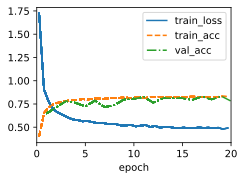

In [225]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)

1b. The results are pretty similar since the baseline didn't have much overfitting. When the weight_decay hyperparameter was set to 0.1, the model was underfitting as the training loss stopped decreasing at a higher loss value. This resulted in lower training and validation accuracy at the time, but changing the hyperparameter to 0.01 provided similar results. The model may be slightly more generalizable since the gap between the accuracies is slightly smaller.

In [226]:
torch.save(model.state_dict(), 'mlp_1b.params')

### 1.c Report section a; this time add dropout (dropout = 0.3). Report and plot your training results. how do the training results change compared to the baseline? How the training results change compared to the weight penalties. (15pts)

In [227]:
# Remove weight decay from optimizer
@d2l.add_to_class(d2l.Classifier)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr) 

In [228]:
# Add dropout layer to model
class MLP_dropout(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.Dropout(0.3), nn.LazyLinear(int(num_hiddens/2)),
                                 nn.ReLU(), nn.Dropout(0.3), nn.LazyLinear(int(num_hiddens/4)),
                                 nn.ReLU(), nn.Dropout(0.3), nn.LazyLinear(num_outputs))

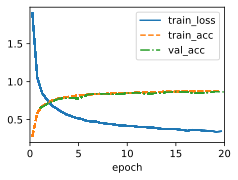

In [229]:
model = MLP_dropout(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)

1c. The results are better than both the baseline and weight decay methods. As it can be seen on the plot above, the generalization gap has been reduced significantly, along with a smoother validation accuracy line. The random increases in generalization gap with the previous trainings have been significantly reduced.

In [230]:
torch.save(model.state_dict(), 'mlp_1c.params')

### 1.d. repeat problems 1.b and 1.c; this time, load the pre-trained parameters from the storage. Plot the training results, and compare the training time and number of epochs needed against 1.b and 1.c. (20pts)

In [258]:
# Load pretrained parameters
model_wd = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
model_wd.load_state_dict(torch.load('mlp_1a.params'))
model_wd.eval()
# Unsure of how to load parameters into a model with different layers, so using the parameters from 1c model
model_dropout = MLP_dropout(num_outputs=10, num_hiddens=256, lr=0.1)
model_dropout.load_state_dict(torch.load('mlp_1c.params'))
model_dropout.eval()

MLP_dropout(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): LazyLinear(in_features=0, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): LazyLinear(in_features=0, out_features=64, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)

In [259]:
# Set weight decay in optimizer
@d2l.add_to_class(d2l.Classifier)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=0.01)

In [17]:
from datetime import datetime

Time to train for weight decay model: 0:02:43.916878


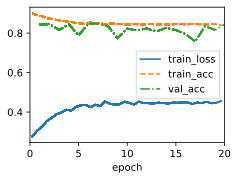

In [261]:
trainer = d2l.Trainer(max_epochs=20)
t_start = datetime.now()
trainer.fit(model_wd, data)
t_end = datetime.now()

print("Time to train for weight decay model:", t_end - t_start)

In [263]:
# Remove weight decay from optimizer for dropout model
@d2l.add_to_class(d2l.Classifier)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)

Time to train for dropout model: 0:02:43.701018


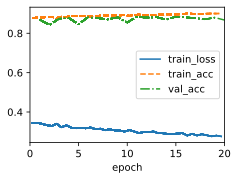

In [264]:
trainer = d2l.Trainer(max_epochs=20)
t_start = datetime.now()
trainer.fit(model_dropout, data)
t_end = datetime.now()

print("Time to train for dropout model:", t_end - t_start)

1d. The training time for both models (weight decay and dropout) were the same, which coincided with the training times of the randomized parameter versions. The number of epochs was set to 20, but it didn't need to run for that many epochs since the models were already starting from a good position with the pretrained parameters. For the weight decay model, the loss ended up increasing through more training. This may have been due to the baseline model having some overfitting, so this may have helped generalize the model.

## Problem 2
For the housing dataset, we overviewed during the lectures; please implemt the following steps.

### 2.a What happens if we need to standardize the continuous numerical features like what we have done in this section? (10pt)

In [4]:
# Class for downloading KaggleHouse
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                                                      sha1_hash='585e9cc93e7039160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                                                      sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [5]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [6]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [7]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding.
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [8]:
data.preprocess()
data.train.shape

(1460, 332)

2a. When standardizing the features in this dataset, it will allow for the model to focus on the features that it should be training from. When there are empty values for certain samples in some features, those empty values should be assigned a value to give it meaning for the model to learn from. Since some values in this dataset vary in magnitudes greatly compared to each other, the values should be standardized to fit within a certain range to give all features a chance to contribute to the training. For features that are labeled to consist of two categorical values, one-hot encoding is used to split this feature into each of its categories and represent them with percentage values (either 0 or 1). This will inherently increase the number of features, which can been seen from the preprocessing performed above.

### 2.b Improve the score by improving the model complexity. Please plot the training results and compare them against the baseline model we did in the lectures. How about the model complexity comparison and training time? (15pt)

In [9]:
# Lecture model performance
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [10]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [11]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the A

average validation log mse = 0.17939144521951672
Training time of lecture model: 0:00:06.554533


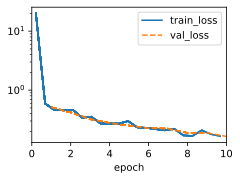

In [274]:
trainer = d2l.Trainer(max_epochs=10)
t_start = datetime.now()
models = k_fold(trainer, data, k=5, lr=0.01)
t_end = datetime.now()

print('Training time of lecture model:', t_end - t_start)

In [12]:
# Improving on lecture model
class model_WDandDropout(d2l.SoftmaxRegression):
    def __init__(self, num_hiddens, lr, dropout, wd):
        super().__init__(num_outputs=1, lr=lr)
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens), nn.ReLU(), nn.Dropout(dropout),
                                 nn.LazyLinear(int(num_hiddens/2)), nn.ReLU(), nn.Dropout(dropout),
                                 nn.LazyLinear(int(num_hiddens/4)), nn.ReLU(), nn.Dropout(dropout),
                                 nn.LazyLinear(int(num_hiddens/8)), nn.ReLU(), nn.Dropout(dropout),
                                 nn.LazyLinear(1))
        def forward(self, x):
            x = self.net(x)
            return x
        def configure_optimizers(self):
            return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=wd)
        def training_step(self, batch):
            l = self.loss(self(*batch[:-1]), batch[-1])
            Y_hat = self(*batch[:-1])
            self.plot('loss', l, train=True)
            self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=True)
            return l
        # This validation step function wouldn't run unless I wrote the cell below this
        def validation_step(self, batch):
            Y_hat = self(*batch[:-1])
            self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
            self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        # This loss function wouldn't run unless I wrote the cell below this
        def loss(self, y_hat, y):
            fn = nn.CrossEntropyLoss()
            return fn(y_hat, y)

In [13]:
@d2l.add_to_class(d2l.Classifier)
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

In [14]:
@d2l.add_to_class(d2l.Classifier)
def validation_step(self, batch):
    Y_hat = self(*batch[:-1])
    self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
    self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

In [15]:
def k_fold(trainer, data, k, num_hiddens, lr, dropout, wd):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = model_WDandDropout(num_hiddens=256, lr=0.01, dropout=0, wd=0)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the A

average validation log mse = 0.03122810535132885
Time to train for complex model: 0:00:12.993209


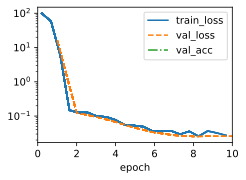

In [18]:
# Training with no dropout or weight decay

# model = model_WDandDropout(num_hiddens=256, lr=0.01, dropout=0, wd=0)
# trainer = d2l.Trainer(max_epochs=20)
# t_start = datetime.now()
# trainer.fit(model, data)
# t_end = datetime.now()

trainer = d2l.Trainer(max_epochs=10)
t_start = datetime.now()
models = k_fold(trainer, data, k=5, num_hiddens=256, lr=0.01, dropout=0, wd=0)
t_end = datetime.now()

print("Time to train for complex model:", t_end - t_start)

2b. With a sacrifice in training time, the complex model was able to reach significantly lower loss. This model (4 hidden layers) is much more complex than the lecture one (1 hidden layer), which resulted in the training learning more but taking longer.

### 2.c How about exploring options for weight decay and dropout over the more complex model? Please plot the results and compare them against 2.b (10pt)

C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the A

average validation log mse = 0.043420053385198124
Time to train for weight decay complex model: 0:00:12.563080


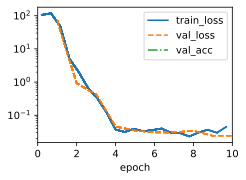

In [19]:
# Using weight decay
trainer = d2l.Trainer(max_epochs=10)
t_start = datetime.now()
models = k_fold(trainer, data, k=5, num_hiddens=256, lr=0.01, dropout=0, wd=0.01)
t_end = datetime.now()

print("Time to train for weight decay complex model:", t_end - t_start)

C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the A

average validation log mse = 0.07741338297724723
Time to train for dropout layer complex model: 0:00:12.870318


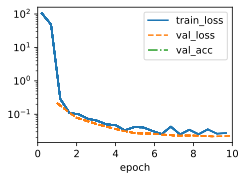

In [20]:
# Using dropout layers
trainer = d2l.Trainer(max_epochs=10)
t_start = datetime.now()
models = k_fold(trainer, data, k=5, num_hiddens=256, lr=0.01, dropout=0.3, wd=0)
t_end = datetime.now()

print("Time to train for dropout layer complex model:", t_end - t_start)

C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\stanl\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the A

average validation log mse = 0.028161785714328293
Time to train for dropout layer complex model: 0:00:12.755438


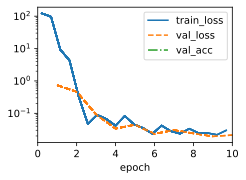

In [21]:
# Using both weight decay and dropout layers
trainer = d2l.Trainer(max_epochs=10)
t_start = datetime.now()
models = k_fold(trainer, data, k=5, num_hiddens=256, lr=0.01, dropout=0.3, wd=0.01)
t_end = datetime.now()

print("Time to train for dropout layer complex model:", t_end - t_start)

2c. With weight decay and dropout, these techniques both decrease the validation loss compared to just the complex model. When incorporating all of these regularization techniques (weight decay, dropout, more complex model), we are able to get our lowest validation loss out of the models trained.

### 2.d Submit your best predictions to Kaggle. How good are your predictions? (5pts)

In [22]:
# Submitting predictions
preds = [model(torch.tensor(data.val.values, dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

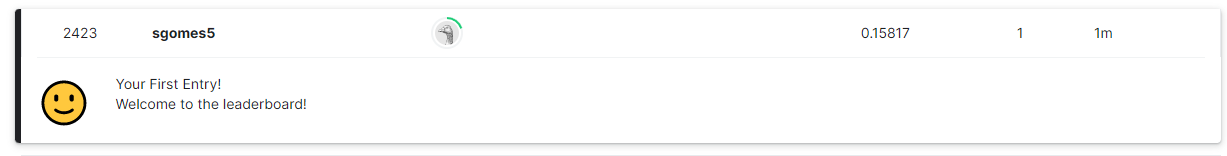

2d. My predictions were not the best and could be tweaked more. I will look into further optimizations and trying different layers to see how they perform. I feel that I was restricted with what I could implement using the D2L API, so I will try implementing from scratch for the next homework.